# Extract embeddings

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b3
import torch.nn as nn
import numpy as np
from tqdm import tqdm


data_path = "./data/FashionMNIST"
output_dir = "./data/FashionMNIST/embeddings"
single_stack_dir = "./data/FashionMNIST/fashion_embeddings_single_stack"
batch_size = 64
embedding_size = 512

os.makedirs(output_dir, exist_ok=True)
os.makedirs(single_stack_dir, exist_ok=True)
train_output_dir = os.path.join(output_dir, "train_embeddings")
test_output_dir = os.path.join(output_dir, "test_embeddings")

os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.FashionMNIST(root=data_path, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=data_path, train=False, download=True, transform=transform)

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = efficientnet_b3(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, out_features=embedding_size)
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

def extract_and_save_embeddings(model, dataloader, device, output_dir, name):
    all_embeddings = []
    labels = []
    index = 0
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting embeddings"):
            print("Image shape:", images.shape)
            images = images.to(device)
            embeddings = model(images)
            print("Embeddings shape:", embeddings.shape)
            for embedding, target in zip(embeddings.cpu(), targets):
                all_embeddings.append(embedding.numpy())
                labels.append(target.item())
                embedding_df = pd.DataFrame(embedding.numpy()).T
                embedding_df['label'] = target.item()
                embedding_csv_path = os.path.join(output_dir, f"{target.item()}_{index}.csv")
                embedding_df.to_csv(embedding_csv_path, index=False)
                index += 1
    consolidated_df = pd.DataFrame(all_embeddings)
    consolidated_df['label'] = labels
    consolidated_csv_path = os.path.join(single_stack_dir, f"{name}_all_embeddings.csv")
    consolidated_df.to_csv(consolidated_csv_path, index=False)
    print(len(consolidated_df), index)

extract_and_save_embeddings(model, dataloader, device, train_output_dir, "train")
extract_and_save_embeddings(model, dataloader_test, device, test_output_dir, "test")

print("Embeddings extracted and saved successfully!")

# Visualize class distributions

Train Embeddings Shape: torch.Size([1, 512]), Labels: tensor([1])
Test Embeddings Shape: torch.Size([1, 512]), Labels: tensor([9])
60000 10000


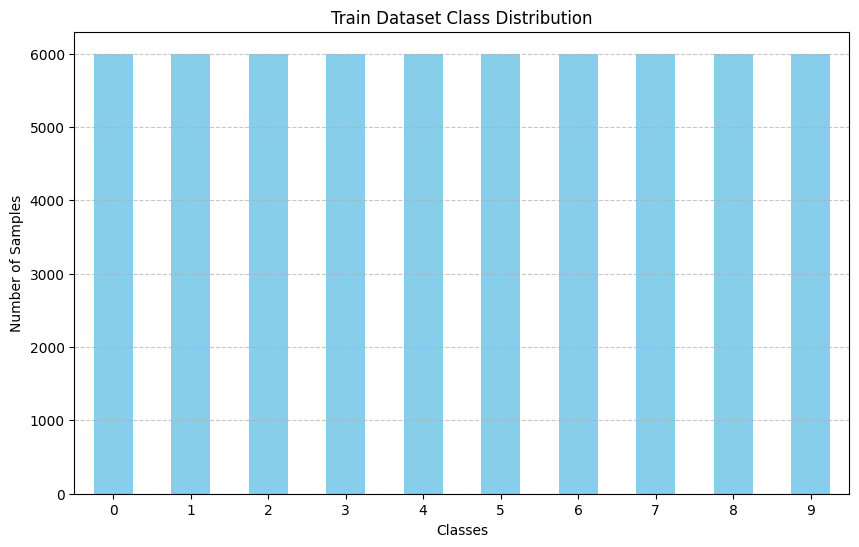

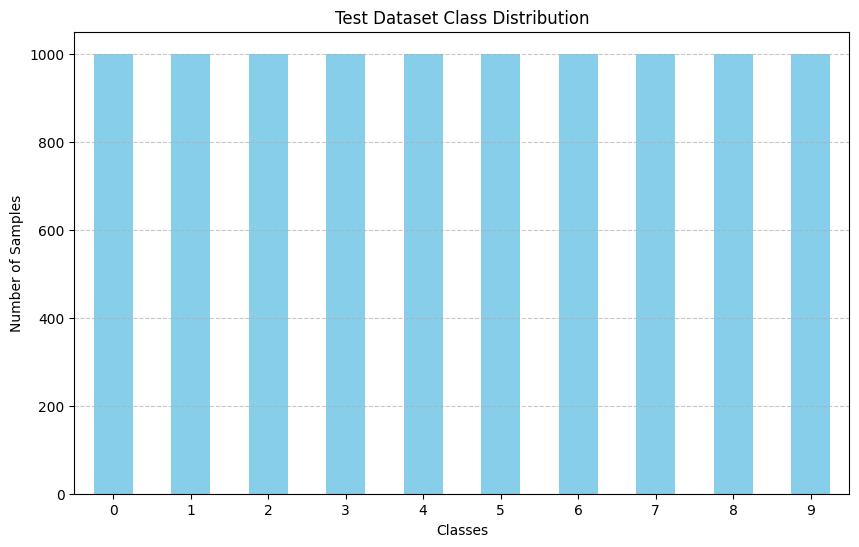

In [3]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import torch

output_dir = "./data/FashionMNIST/fashion_embeddings_single_stack"

batch_size = 1


class EmbeddingDataset(Dataset):
    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file)
        self.embeddings = self.data_frame.iloc[:, :-1].values
        self.labels = self.data_frame['label'].values

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embedding, label


train_embeddings_file = os.path.join(output_dir, "train_all_embeddings.csv")
test_embeddings_file = os.path.join(output_dir, "test_all_embeddings.csv")

train_dataset_loaded = EmbeddingDataset(train_embeddings_file)
test_dataset_loaded = EmbeddingDataset(test_embeddings_file)

train_dataloader_loaded = DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
test_dataloader_loaded = DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)

for embeddings, labels in train_dataloader_loaded:
    print(f"Train Embeddings Shape: {embeddings.shape}, Labels: {labels}")
    break

for embeddings, labels in test_dataloader_loaded:
    print(f"Test Embeddings Shape: {embeddings.shape}, Labels: {labels}")
    break
print(len(train_dataloader_loaded), len(test_dataloader_loaded))

def plot_class_distribution(dataset, title):
    label_counts = pd.Series(dataset.labels).value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_distribution(train_dataset_loaded, "Train Dataset Class Distribution")
plot_class_distribution(test_dataset_loaded, "Test Dataset Class Distribution")

In [4]:
%cd ./data/FashionMNIST
!zip -r fashion_embeddings_single_stack.zip fashion_embeddings_single_stack
!zip -r fashion_embeddings.zip embeddings

Streaming output truncated to the last 5000 lines.
  adding: embeddings/test_embeddings/8_8895.csv (deflated 54%)
  adding: embeddings/test_embeddings/3_1994.csv (deflated 54%)
  adding: embeddings/test_embeddings/2_6478.csv (deflated 54%)
  adding: embeddings/test_embeddings/1_1464.csv (deflated 54%)
  adding: embeddings/test_embeddings/8_3611.csv (deflated 54%)
  adding: embeddings/test_embeddings/0_1100.csv (deflated 54%)
  adding: embeddings/test_embeddings/1_1612.csv (deflated 54%)
  adding: embeddings/test_embeddings/3_8089.csv (deflated 54%)
  adding: embeddings/test_embeddings/9_4256.csv (deflated 54%)
  adding: embeddings/test_embeddings/5_475.csv (deflated 54%)
  adding: embeddings/test_embeddings/1_5705.csv (deflated 54%)
  adding: embeddings/test_embeddings/6_8031.csv (deflated 54%)
  adding: embeddings/test_embeddings/4_9164.csv (deflated 54%)
  adding: embeddings/test_embeddings/7_3871.csv (deflated 54%)
  adding: embeddings/test_embeddings/2_7892.csv (deflated 54%)
  add